In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Data Preprocessing

In [2]:
data = pd.read_csv('../../delivery/data/data_train.csv', index_col=0)

# rename column and turn ot uint8
data.rename(columns={'Prediction': 'Rating'}, inplace=True)
data['Rating'] = data['Rating'].astype('uint8')

# get user and movie id by splitting index given in format rX_cY
data['UserId'] = data.index.str.split('_').str[0].str[1:].astype('int32')
data['MovieId'] = data.index.str.split('_').str[1].str[1:].astype('int32')

# subtract min UserId and MovieID to get indices starting at 0
data['UserId'] = data['UserId'] - data['UserId'].min()
data['MovieId'] = data['MovieId'] - data['MovieId'].min()

# make int again
data['UserId'] = data['UserId'].astype('int32')
data['MovieId'] = data['MovieId'].astype('int32')

# reorder columns to UserId, MovieId, Rating
data = data[['UserId', 'MovieId', 'Rating']]

# split into train and val data
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [3]:
train_data.head()

,UserId,MovieId,Rating
Id,,,
r5874_c663,5873,662,5
r4711_c367,4710,366,4
r2539_c435,2538,434,1
r7737_c558,7736,557,2
r9631_c791,9630,790,5


In [4]:
train_data.describe()

,UserId,MovieId,Rating
count,941561.000000,941561.000000,941561.000000
mean,5149.112369,482.580407,3.856588
std,2918.447452,274.174986,1.119108
min,0.000000,0.000000,1.000000
25%,2602.000000,246.000000,3.000000
50%,5247.000000,493.000000,4.000000
75%,7734.000000,690.000000,5.000000
max,9999.000000,999.000000,5.000000


In [5]:
normalize_by = "MovieId"

train_mean = train_data.groupby(by=normalize_by)['Rating'].mean()
train_std = train_data.groupby(by=normalize_by)['Rating'].std()
train_data.Rating = (train_data.Rating - train_mean.values[train_data[normalize_by]])/train_std.values[train_data[normalize_by]]

In [6]:
# function to get sparse matrix from data given as a dataframe with row and column indices
def get_sparse_matrix(data, n_rows, n_cols):
    return csr_matrix((data['Rating'].values, (data['UserId'].values, data['MovieId'].values)), shape=(n_rows, n_cols))

n_rows = train_data['UserId'].max() + 1 # might raise errors if in val set user with larger id
n_cols = train_data['MovieId'].max() + 1 # might raise errors if in val set movie with larger id
train_matrix = get_sparse_matrix(train_data, n_rows, n_cols)

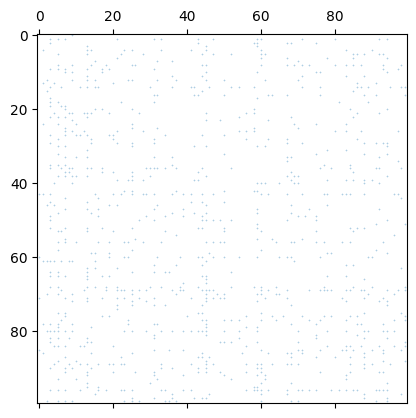

In [7]:
# plot sparse matrix
plt.spy(train_matrix[:100,:100], markersize=0.1)
plt.show()

# KNN

In [8]:
similarities = cosine_similarity(train_matrix.T, train_matrix.T)

In [9]:
def make_predictions(k, val_data, train_std, train_mean, max_elements=None):
    if max_elements is None:
        max_elements = val_data.shape[0]
    
    predictions = np.zeros(val_data.shape[0])
    similarity_scores = np.zeros(val_data.shape[0])
    for i in tqdm(range(max_elements)):
        user_id, movie_id = val_data.iloc[i][['UserId', 'MovieId']]

        user_id = int(user_id)
        movie_id = int(movie_id)

        rated_movies = train_matrix[user_id].nonzero()[1]
        nearest_movies = rated_movies[np.argsort(similarities[movie_id, rated_movies])[-k:]]
        
        similarity_scores[i] = np.sort(similarities[movie_id, rated_movies])[-k:].mean()

        prediction = train_matrix[user_id, nearest_movies].mean()
        predictions[i] = prediction * train_std[movie_id] + train_mean[movie_id]
    return predictions, similarity_scores

# predictions = make_predictions(5, val_data, train_std, train_mean, 2)

In [10]:
max_elements = 1000

k_array = np.arange(1, 50, 5)
rmse_array = []

for k in k_array:
    predictions, similarity_scores = make_predictions(k, val_data, train_std, train_mean, max_elements)
    rmse = mean_squared_error(val_data['Rating'][:max_elements], predictions[:max_elements], squared=False)
    rmse_array.append(rmse)

 64%|██████▍   | 638/1000 [00:00<00:00, 1977.55it/s]


KeyboardInterrupt: 

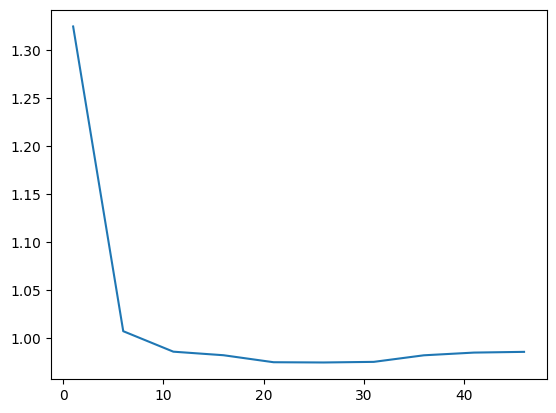

Best k: 26
Best RMSE: 0.9747686695907558


In [ ]:
plt.plot(k_array, rmse_array)
plt.show()

print('Best k: {}'.format(k_array[np.argmin(rmse_array)]))
print('Best RMSE: {}'.format(np.min(rmse_array)))

In [ ]:
# best_k = k_array[np.argmin(rmse_array)]
best_k = 26
predictions, similarity_scores  = make_predictions(best_k, val_data, train_std, train_mean)
val_data['Prediction'] = predictions
val_data['Similarity'] = similarity_scores

  7%|▋         | 16276/235391 [00:06<01:31, 2384.99it/s]


KeyboardInterrupt: 

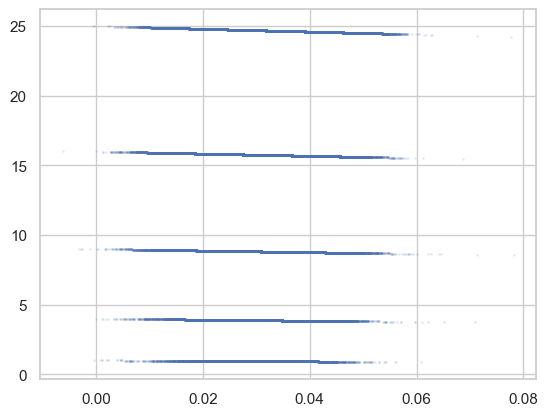

In [ ]:
mse = (val_data['Rating'] - val_data['Similarity'])**2
plt.scatter(val_data['Similarity'], mse, alpha=0.1, s=1)
plt.show()

In [ ]:
val_data.head()

,UserId,MovieId,Rating,Prediction,Similarity
Id,,,,,
r5062_c706,5061,705,2,3.450599,0.026031
r9044_c148,9043,147,4,4.058141,0.037758
r1736_c169,1735,168,4,4.497718,0.032954
r5270_c877,5269,876,1,3.470415,0.031948
r6100_c691,6099,690,4,3.759279,0.026318


In [ ]:
# compute rmse using sklearn
rmse_3 = mean_squared_error(val_data['Rating'], 3 * np.ones(val_data.shape[0]), squared=False)
rmse_mean_overall = mean_squared_error(val_data['Rating'], train_mean.mean() * np.ones(val_data.shape[0]), squared=False)
rmse_mean = mean_squared_error(val_data['Rating'], train_mean[val_data.MovieId], squared=False)
rmse_knn = mean_squared_error(val_data['Rating'], val_data['Prediction'], squared=False)
print('Dummy RMSE: {}'.format(rmse_3))
print('Mean RMSE: {}'.format(rmse_mean_overall))
print('Movie Mean RMSE: {}'.format(rmse_mean))
print('KNN RMSE: {}'.format(rmse_knn))

Dummy RMSE: 1.4112094086052875
Mean RMSE: 1.148036283409983
Movie Mean RMSE: 1.0309495525701207
KNN RMSE: 0.9925058600964632


In [ ]:
val_data['Prediction'].to_csv(f"../../delivery/outputs/KNN/predictions_knn_val.csv")

In [ ]:
val_data['Similarity'].to_csv(f"../../delivery/outputs/KNN/similarity_knn_val.csv")

# make test predictions

In [ ]:
def load_cil(dataset="split"):

    file = "data_train" if dataset != "test" else "sampleSubmission"
    data = pd.read_csv(f'../../delivery/data/{file}.csv', index_col=0)
    data['UserId'] = data.index.str.split('_').str[0].str[1:].astype('int32')
    data['MovieId'] = data.index.str.split('_').str[1].str[1:].astype('int32')
    data.rename(columns={'Prediction': 'rating'}, inplace=True)
    data['rating'] = data['rating'].astype('uint8')
    data = data[['UserId', 'MovieId', 'rating']]

    data['UserId'] = data['UserId'] - 1
    data['MovieId'] = data['MovieId'] - 1
    print("Subtracted {} from user and movie".format(1))

    user_num = 10000  # int(data['user'].max() + 1)
    movie_num = 1000  # int(data['movie'].max() + 1)
    print("User num: {}, Movie num: {}".format(user_num, movie_num))

    train_data = val_data = None
    if dataset == "test":
        val_data = data
    elif dataset == "train":
        train_data = data
    else:
        train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    return train_data, val_data, user_num, movie_num

In [ ]:
_, test_data, _, _ = load_cil(dataset="test")

Subtracted 1 from user and movie
User num: 10000, Movie num: 1000


In [ ]:
print(test_data.head())

         user  movie  rating
Id                          
r37_c1     36      0       3
r73_c1     72      0       3
r156_c1   155      0       3
r160_c1   159      0       3
r248_c1   247      0       3


In [ ]:
train_data = data
normalize_by = "MovieId"
train_mean = train_data.groupby(by=normalize_by)['Rating'].mean()
train_std = train_data.groupby(by=normalize_by)['Rating'].std()
train_data.Rating = (train_data.Rating - train_mean.values[train_data[normalize_by]])/train_std.values[train_data[normalize_by]]

n_rows = train_data['UserId'].max() + 1 # might raise errors if in val set user with larger id
n_cols = train_data['MovieId'].max() + 1 # might raise errors if in val set movie with larger id
train_matrix = get_sparse_matrix(train_data, n_rows, n_cols)

similarities = cosine_similarity(train_matrix.T, train_matrix.T)

In [ ]:
best_k = 26
predictions, similarity_scores  = make_predictions(best_k, test_data, train_std, train_mean)
test_data['Prediction'] = predictions
test_data['Similarity'] = similarity_scores

100%|██████████| 1176952/1176952 [06:36<00:00, 2967.53it/s]


In [ ]:
test_data['Prediction'].to_csv(f"../../delivery/outputs/KNN/predictions_knn_test.csv")
test_data['Similarity'].to_csv(f"../../delivery/outputs/KNN/similarity_knn_test.csv")